In [32]:
import bat
from bat.log_to_dataframe import LogToDataFrame
from bat.dataframe_to_matrix import DataFrameToMatrix
print('bat: {:s}'.format(bat.__version__))
import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)

bat: 0.3.7
Pandas: 0.24.2
Numpy: 1.16.2
Scikit Learn Version: 0.21.2


In [53]:
# Create a Pandas dataframe from the Bro HTTP log
log_to_df = LogToDataFrame()
bro_df = log_to_df.create_dataframe('http.log')
print('Read in {:d} Rows...'.format(len(bro_df)))
bro_df.head()

TypeError: cannot safely cast non-equivalent int32 to uint64

In [34]:
# We're going to pick some features that might be interesting
# some of the features are numerical and some are categorical
features = ['id.resp_p', 'method', 'resp_mime_types', 'request_body_len']

In [35]:
# Show the dataframe with mixed feature types
bro_df[features].head()

,id.resp_p,method,resp_mime_types,request_body_len
ts,,,,
2019-07-19 18:52:35.253660917,80,GET,text/plain,0
2019-07-19 18:52:56.362874031,80,GET,NaN,0
2019-07-19 18:52:56.402968884,80,GET,text/html,0
2019-07-19 18:52:59.317110062,80,GET,text/plain,0
2019-07-19 18:52:59.363258123,80,GET,text/plain,0


In [36]:
# Use the bat DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix()
bro_matrix = to_matrix.fit_transform(bro_df[features], normalize=True)
print(bro_matrix.shape)
bro_matrix[:1]

Normalizing column id.resp_p...
Normalizing column request_body_len...
(236, 17)


array([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [37]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(behaviour='new', contamination=0.25) # Marking 25% odd
odd_clf.fit(bro_matrix)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.25,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [38]:
# Now we create a new dataframe using the prediction from our classifier
odd_df = bro_df[features][odd_clf.predict(bro_matrix) == -1]
print(odd_df.shape)
odd_df.head()

(52, 4)


,id.resp_p,method,resp_mime_types,request_body_len
ts,,,,
2019-07-19 18:52:56.362874031,80,GET,NaN,0
2019-07-19 18:52:56.402968884,80,GET,text/html,0
2019-07-19 18:53:00.372859955,80,GET,application/font-woff2,0
2019-07-19 18:53:00.377995014,80,GET,application/font-woff2,0
2019-07-19 18:53:00.416703939,80,GET,application/font-woff2,0


In [39]:
# Now we're going to explore our odd dataframe with help from KMeans and PCA algorithms
odd_matrix = to_matrix.fit_transform(odd_df)

Normalizing column id.resp_p...
Normalizing column request_body_len...


In [54]:
# Just some simple stuff for this example, KMeans and PCA
kmeans = KMeans(n_clusters=4).fit_predict(odd_matrix)  # Change this to 3/5 for fun
pca = PCA(n_components=3).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe!
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans
odd_df.head()

,id.resp_p,method,resp_mime_types,request_body_len,x,y,cluster,jx,jy
ts,,,,,,,,,
2019-07-19 18:52:56.362874031,80,GET,NaN,0,0.060715,-0.183673,0,0.130282,-0.148591
2019-07-19 18:52:56.402968884,80,GET,text/html,0,-0.261086,-0.199242,0,-0.304061,-0.194702
2019-07-19 18:53:00.372859955,80,GET,application/font-woff2,0,-0.368763,-0.608084,0,-0.346647,-0.578827
2019-07-19 18:53:00.377995014,80,GET,application/font-woff2,0,-0.368763,-0.608084,0,-0.334303,-0.614366
2019-07-19 18:53:00.416703939,80,GET,application/font-woff2,0,-0.368763,-0.608085,0,-0.368347,-0.611985


In [55]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

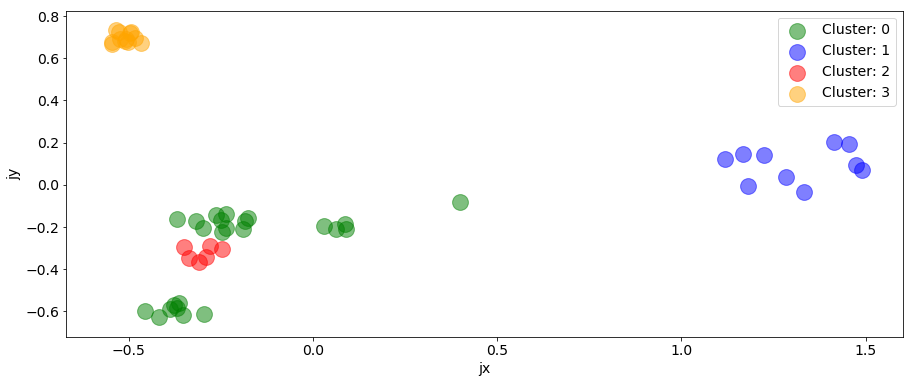

In [56]:
# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [57]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 24 observations
                               id.resp_p method         resp_mime_types  request_body_len
ts                                                                                       
2019-07-19 18:52:56.362874031         80    GET                     NaN                 0
2019-07-19 18:52:56.402968884         80    GET               text/html                 0
2019-07-19 18:53:00.372859955         80    GET  application/font-woff2                 0
2019-07-19 18:53:00.377995014         80    GET  application/font-woff2                 0
2019-07-19 18:53:00.416703939         80    GET  application/font-woff2                 0

Cluster 1: 10 observations
                               id.resp_p method resp_mime_types  request_body_len
ts                                                                               
2019-07-19 18:53:00.644175053         80   POST      text/plain               180
2019-07-19 18:53:12.186537981         80   POST      text/plain     

In [58]:
odd_df[odd_df['cluster'] == 0]

,id.resp_p,method,resp_mime_types,request_body_len,x,y,cluster,jx,jy
ts,,,,,,,,,
2019-07-19 18:52:56.362874031,80,GET,NaN,0,0.060715,-0.183673,0,0.089157,-0.210773
2019-07-19 18:52:56.402968884,80,GET,text/html,0,-0.261086,-0.199242,0,-0.250056,-0.167775
2019-07-19 18:53:00.372859955,80,GET,application/font-woff2,0,-0.368763,-0.608084,0,-0.418552,-0.626093
2019-07-19 18:53:00.377995014,80,GET,application/font-woff2,0,-0.368763,-0.608084,0,-0.368372,-0.584565
2019-07-19 18:53:00.416703939,80,GET,application/font-woff2,0,-0.368763,-0.608085,0,-0.296670,-0.611483
2019-07-19 18:53:00.448777914,80,GET,application/font-woff2,0,-0.368763,-0.608084,0,-0.361945,-0.559731
2019-07-19 18:53:00.963830948,80,GET,image/gif,0,-0.277718,-0.182617,0,-0.368685,-0.160001
2019-07-19 18:53:00.445668936,80,GET,application/font-woff,0,-0.252756,-0.142684,0,-0.235067,-0.137346
2019-07-19 18:53:01.065693854,80,GET,image/gif,0,-0.277718,-0.182617,0,-0.236901,-0.202961


In [51]:
bro_df[bro_df['method']]

KeyError: "None of [Index([ 'GET',  'GET',  'GET',  'GET',  'GET',  'GET',  'GET',  'GET',  'GET',  'GET',\n       ...\n       'POST', 'POST', 'POST', 'POST', 'POST', 'POST', 'POST', 'POST', 'POST', 'POST'], dtype='object', length=236)] are in the [columns]"

In [28]:
conn_df = log_to_df.create_dataframe('conn.log')

In [31]:
conn_df[conn_df['uid'] == "CqcAot4VXRMomlg5S3"]

,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
ts,,,,,,,,,,,,,,,,,,,,
2019-07-19 18:57:23.534814119,CqcAot4VXRMomlg5S3,172.16.4.205,49255,31.7.62.214,443,tcp,http,01:50:24.653597,26279,519,S1,NaN,NaN,0,ShADda,116,30931,115,5131,(empty)
